In [21]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import pairwise_distances, mean_squared_error, mean_absolute_error
from scipy.stats.stats import pearsonr
from scipy.spatial.distance import squareform, pdist
from sklearn.neighbors import NearestNeighbors
from numpy.linalg import norm
from math import isnan
import time

# MovieLens 100K
data=pd.read_table('D:/collaborative_filtering/movielens/order/u.data', names=['uid','iid','r','ts'])

#%% Similarity


def sim_cos(u,v):
    
    ind=np.where((1*(u==-1)+1*(v==-1))==0)[0]
    if len(ind) > 0:
        up = sum(u[ind] * v[ind])
        down = norm(u[ind]) * norm(v[ind])
        cos_sim = up/down
        if not isnan(cos_sim):
            return cos_sim
        else:
            return 0
    else:
        return 0

def sim_msd(u,v):
    ind=np.where((1*(u==-1)+1*(v==-1))==0)[0]
    
    if len(ind)>0:
        msd_sim = 1 - np.sum((u[ind]/5-v[ind]/5)**2)/len(ind)
        return msd_sim
    else:
        return 0

def sim_pcc(u,v):
    ind=np.where((1*(u==-1)+1*(v==-1))==0)[0]
    if len(ind)>1:
        u_m = np.mean(u[ind])
        v_m = np.mean(v[ind])
        if (norm(u[ind]-u_m)*norm(v[ind]-v_m))>0:
            return np.sum((u[ind]-u_m)*(v[ind]-v_m)) / (norm(u[ind]-u_m)*norm(v[ind]-v_m)) # range(-1,1)
        else:
            return 0
    else:
        return 0  
    
def sim_jac(u,v):
    ind1=np.where((1*(u==-1)+1*(v==-1))==0)[0]
    ind2=np.where((1*(u==-1)+1*(v==-1))!=2)[0] #합집합
    return len(ind1)/len(ind2)



#%% Initialize
save_result=dict()
save_f1_result=dict()
save_ad_result=dict()


#%% Predict ratings
cv=5
rs=35
sk=StratifiedKFold(n_splits=cv, random_state=rs, shuffle=True)
rmed=np.median(list(set(data['r'])))
ignore_missing=True

# 원하는 sim_name 입력
sim_names=['PCC','COS','JAC','MSD']


s=5
table_com2 = pd.DataFrame(columns=['MSE','MAE'])
table_com = pd.DataFrame(columns=['Precision','Recall','F1_score'])


for sim_name in sim_names:
    t1=time.time()
    summary=pd.DataFrame(columns=['fold','k','MSE','MAE'])
    result_f1 = pd.DataFrame(columns=['fold','k','Precision','Recall','F1_score'])
    count=0
    count2=0
    print(f'similarity:{sim_name}')
    for f, (trn,val) in enumerate(sk.split(data,data['uid'].values)):
        print(f'{f+1}th cv')
        trn_data=data.iloc[trn]
        val_data=data.iloc[val]
        u_mean = trn_data.groupby(['uid'])['r'].mean().reset_index()
        u_mean = u_mean.rename(columns={'r':'r_mean'})
        tb=pd.pivot_table(trn_data, index='uid', columns='iid', values='r')
        n_item=tb.shape[1]  
        if sim_name=='PCC':
            sim=pdist(tb.fillna(-1),metric=sim_pcc)
        elif sim_name=='COS':
            sim=pdist(tb.fillna(-1),metric=sim_cos)
        elif sim_name=='JAC':
            sim=pdist(tb.fillna(-1),metric=sim_jac)
        elif sim_name=='MSD':
            sim=pdist(tb.fillna(-1),metric=sim_msd)

        #dist=squareform(dist)
        sim=squareform(sim)
        np.fill_diagonal(sim,-1)   
        #nb_ind=np.argsort(dist,axis=1)
        nb_ind=np.argsort(sim,axis=1)[:,::-1]
        for k in [10,20,30,40,50,60,70,80,90,100]:
            print(f'k={k}')
            sel_nn=nb_ind[:,:k]
            sel_sim=sim[tuple(np.tile(np.arange(len(tb))[:,None],(1,k))),tuple(sel_nn)]
            sel_nn=[[tb.index.values[i],tb.index.values[j],s] for i in range(len(tb)) for j,s in zip(sel_nn[i],sel_sim[i])]
            sel_nn=pd.DataFrame(sel_nn, columns=['uid','nn_uid','sim'])

            pred_data=val_data.merge(sel_nn, on=['uid'])#
            pred_data=pred_data.merge(trn_data.drop(['ts'],axis=1).rename(columns={'uid':'nn_uid'}), on=['nn_uid','iid'])#
            #pred_data=pred_data.merge(u_mean, on='uid')
            pred_data=pred_data.merge(u_mean.rename(columns={'uid':'nn_uid','r_mean':'nn_r_mean'}), on='nn_uid')#
            pred_data['sim_r_diff']=(pred_data['r_y']-pred_data['nn_r_mean'])*pred_data['sim']#
            #inner조인 방식이라 양쪽 데이터프레임에 존재하는것만 merge! 여기선 pred_data와 trn_data에서 nn_uid와 iid 존재하는 것만 merge
            #기준 열이 아니면서 이름이 같은 열에는 _x 또는 _y 와 같은 접미사가 붙는다. r_x, r_y
            pred_data2=pred_data.groupby(['uid','iid','r_x'])['sim_r_diff'].sum().to_frame()#
            pred_data2['sim_sum']=pred_data.groupby(['uid','iid','r_x'])['sim'].apply(lambda x: np.sum(np.abs(x)))#
            pred_data2=pred_data2.reset_index()#
            pred_data2=val_data.drop('ts',axis=1).rename(columns={'r':'r_x'}).merge(pred_data2, on=['uid','iid','r_x'], how='left')#
            pred_data2=pred_data2.merge(u_mean, on=['uid'])#
            pred_data2['r_pred']=pred_data2['r_mean']+pred_data2['sim_r_diff']/pred_data2['sim_sum']#

            if ignore_missing:
                pred_data2=pred_data2[pred_data2['r_pred'].isnull()==False]#
            else:
                pred_data2.loc[pred_data2['r_pred'].isnull(),'r_pred']=pred_data2.loc[pred_data2['r_pred'].isnull(),'r_mean'] 
                #r_pred 값이 nan 값이 나오면 r_mean 값으로 대체
                # -> train 데이터에 사용자 u와의 유사도가 0보다 큰 사용자 v가 없고 u의 평점이 vaild 데이터에 존재하면 sim_sum 값은 0이 됨 -> 그럴 때 u의 평균값으로 대체
            summary.loc[count]=[f,k,mean_squared_error(pred_data2['r_x'],pred_data2['r_pred']),mean_absolute_error(pred_data2['r_x'],pred_data2['r_pred'])]

            count += 1
            # precision, recall, f1-score

            TPP = len(set(np.where(np.array(pred_data2['r_pred'])>=pred_data2['r_mean'])[0]).intersection(set(np.where(np.array(pred_data2['r_x'])>=pred_data2['r_mean'])[0])))
            FPP = len(set(np.where(np.array(pred_data2['r_pred'])>=pred_data2['r_mean'])[0]).intersection(set(np.where(np.array(pred_data2['r_x'])<pred_data2['r_mean'])[0])))
            FNP = len(set(np.where(np.array(pred_data2['r_pred'])<pred_data2['r_mean'])[0]).intersection(set(np.where(np.array(pred_data2['r_x'])>=pred_data2['r_mean'])[0])))
            _precision = TPP / (TPP + FPP)
            _recall = TPP / (TPP + FNP)
            _f1_score = 2 * _precision * _recall / (_precision + _recall)
            result_f1.loc[count2] = [f, k, _precision, _recall, _f1_score]

            count2 += 1
            

    summary2=summary.groupby(['k'])[['MSE','MAE']].mean()
    save_result[sim_name]=summary2.copy()
    summary2['sim_name'] = sim_name
    table_com2 = pd.concat([table_com2, summary2], axis=0)
    result_2 = result_f1.groupby(['k']).mean().drop(columns=['fold'])
    save_f1_result[sim_name]=result_2.copy()
    result_2['sim_name'] = sim_name
    table_com = pd.concat([table_com, result_2], axis=0)
    print(time.time() - t1)

similarity:PCC
1th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
2th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
3th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
4th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
5th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
264.66371750831604
similarity:COS
1th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
2th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
3th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
4th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
5th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
187.25023198127747
similarity:JAC
1th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
2th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
3th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
4th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
5th cv
k=10
k=20
k=30
k=40
k=50
k=60
k=70
k=80
k=90
k=100
304.31908917427063
similarity:MSD
1th cv
k=10
k

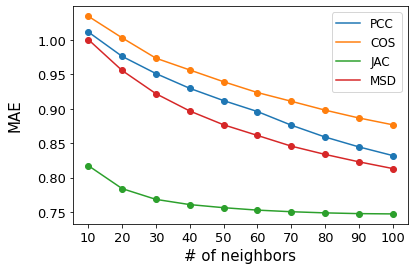

In [24]:
parameters = {'xtick.labelsize': 13,
          'ytick.labelsize': 13,
             'legend.fontsize' : 12}
plt.rcParams.update(parameters)
for _ in sim_names :
    plt.scatter(np.arange(10,110,10),table_com2[table_com2['sim_name']==_]['MAE'])
    plt.plot(np.arange(10,110,10),table_com2[table_com2['sim_name']==_]['MAE'],label=_)
    plt.xticks(np.arange(10,110,10))
    plt.xlabel('# of neighbors', fontsize=15)
    plt.ylabel('MAE', fontsize=15,labelpad = 15)
    plt.legend()

plt.show()

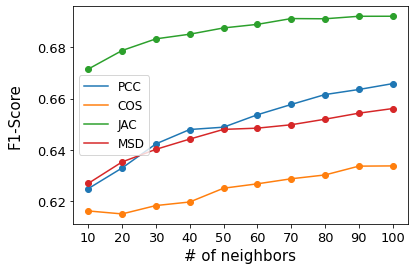

In [25]:
parameters = {'xtick.labelsize': 13,
          'ytick.labelsize': 13,
             'legend.fontsize' : 12}
plt.rcParams.update(parameters)
for _ in sim_names :
    plt.scatter(np.arange(10,110,10),table_com[table_com['sim_name']==_]['F1_score'])
    plt.plot(np.arange(10,110,10),table_com[table_com['sim_name']==_]['F1_score'],label=_)
    plt.xticks(np.arange(10,110,10))
    plt.xlabel('# of neighbors', fontsize=15)
    plt.ylabel('F1-Score', fontsize=15,labelpad = 15)
    plt.legend()

plt.show()
    
    